In [133]:
!pip install pandas
!pip install gender-guesser

In [67]:
import pandas as pd
import numpy as np
import gender_guesser.detector as gender
import random

#### Load Datasets

In [68]:
baby_names = pd.read_csv("../data/Popular_Baby_Names_20240424.csv")
expense_budget = pd.read_csv("../data/Expense_Budget_20240424.csv", low_memory=False)
payroll = pd.read_csv("../data/Citywide_Payroll_Data__Fiscal_Year__20240424.csv", low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/Popular_Baby_Names_20240424.csv'

#### Data Cleaning

##### Payroll

In [69]:
payroll.isnull().any(axis=0)

Fiscal Year              False
Agency                   False
Work Location Borough    False
Base Salary              False
Pay Basis                False
Regular Hours            False
Regular Gross Paid       False
OT Hours                 False
Total OT Paid            False
Total Other Pay          False
Gender                   False
dtype: bool

Filter out all the rows that are missing names. We can't do gender analysis on them. There are 13,245 rows with missing names. 

In [70]:
payroll = payroll[payroll["First Name"].notna()]

KeyError: 'First Name'

Filter out all the rows that are missing start dates. There are only 63 rows with missing start dates. 

In [71]:
payroll = payroll[payroll["Agency Start Date"].notna()]


KeyError: 'Agency Start Date'

There are 506,233 rows with missing Work Location Borough. Since the number of missing names is large, we shouldn't just get rid of them. Some people might work in many different buroughs due to the nature of their jobs. Since this is a categorical value, we can have an extra value "Unknown" for any one with missing burough information. 

In [139]:
payroll["Work Location Borough"] = payroll["Work Location Borough"].fillna("UNKNOWN")

In [140]:
payroll['Agency Name'].value_counts()

Agency Name
DEPT OF ED PEDAGOGICAL            1099217
DEPT OF ED PER SESSION TEACHER     910621
POLICE DEPARTMENT                  536182
DEPT OF ED PARA PROFESSIONALS      371390
BOARD OF ELECTION POLL WORKERS     344458
                                   ...   
BRONX COMMUNITY BOARD #12              26
DISTRICTING COMMISSION                 24
BRONX COMMUNITY BOARD #1               21
BRONX COMMUNITY BOARD #3               19
BOARD OF CORRECTIONS                   17
Name: count, Length: 167, dtype: int64

##### Expense Budget

In [141]:
expense_budget["Agency Name"].values

array(['MAYORALTY', 'MAYORALTY', 'MAYORALTY', ...,
       'PUBLIC ADMINISTRATOR-RICHMOND COUNTY',
       'PUBLIC ADMINISTRATOR-RICHMOND COUNTY',
       'PUBLIC ADMINISTRATOR-RICHMOND COUNTY'], dtype=object)

#### Getting Gender Information

Checking overlap between baby names and payroll data

In [142]:
unique_baby = baby_names[baby_names["Child's First Name"].notnull()]
unique_payroll = payroll[payroll["First Name"].notnull()]

unique_baby = baby_names["Child's First Name"].unique()
unique_payroll = payroll["First Name"].unique()

unique_payroll = unique_payroll.astype(str)
unique_baby = unique_baby.astype(str)

unique_baby = np.char.upper(unique_baby)
unique_payroll = np.char.upper(unique_payroll)

len(np.intersect1d(unique_baby, unique_payroll))

1804

Use a gender prediction model

In [143]:
genModel = gender.Detector()

#run through model
def get_gender(name):
    return genModel.get_gender(name.capitalize())

payroll['Gender'] = payroll['First Name'].apply(get_gender)

#handle cases where the model is unsure and assign a gender
def finalize_gender(gender):
    if gender == "mostly_female":
        return "female"
    elif gender == "mostly_male":
        return "male"
    elif gender == "male" or gender == "female":
        return gender
    else:
        return random.choice(["male", "female"])
    
payroll['Gender'] = payroll['Gender'].apply(finalize_gender)
    

In [144]:
payroll['Gender'].value_counts()

Gender
female    3246169
male      2403299
Name: count, dtype: int64

#### Output the data in a json file

In [148]:
payroll.to_json("../data/output/payroll.json", orient='records')

In [ ]:
payroll.to_csv("../data/output/payroll.csv")

In [17]:
payroll[:1500].to_csv("../data/small.csv")

In [48]:
payroll.columns

Index(['Fiscal Year', 'Payroll Number', 'Agency Name', 'Last Name',
       'First Name', 'Mid Init', 'Agency Start Date', 'Work Location Borough',
       'Title Description', 'Leave Status as of June 30', 'Base Salary',
       'Pay Basis', 'Regular Hours', 'Regular Gross Paid', 'OT Hours',
       'Total OT Paid', 'Total Other Pay', 'Gender'],
      dtype='object')

In [50]:
payroll.drop(['Agency Name', 'Last Name',
       'First Name', 'Mid Init', 'Agency Start Date','Leave Status as of June 30'], axis=1, inplace=True)
payroll

KeyError: "['Agency Name', 'Last Name', 'First Name', 'Mid Init', 'Agency Start Date', 'Leave Status as of June 30'] not found in axis"

In [53]:
payroll.drop(['Title Description'], axis=1, inplace=True)
payroll

,Fiscal Year,Payroll Number,Work Location Borough,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,Gender
0,2021,300.0,MANHATTAN,1.00,per Hour,0.0,350.00,0.00,0.00,0.00,female
1,2021,72.0,QUEENS,114617.00,per Annum,2080.0,113582.67,416.25,35400.72,12301.53,female
2,2020,747.0,MANHATTAN,33.18,per Day,0.0,6964.07,0.00,0.00,1046.95,male
3,2015,NaN,MANHATTAN,33.18,per Day,0.0,5087.00,0.00,0.00,3.08,female
4,2021,25.0,MANHATTAN,94883.00,per Annum,1564.5,81332.24,0.00,0.00,-1442.70,female
...,...,...,...,...,...,...,...,...,...,...,...
5649463,2022,466.0,MANHATTAN,44.23,per Hour,357.0,15882.29,0.00,0.00,0.00,male
5649464,2015,NaN,QUEENS,58964.00,per Annum,1825.0,61642.58,126.00,4614.63,3801.18,male
5649465,2019,742.0,MANHATTAN,108780.00,per Annum,0.0,114409.89,0.00,0.00,0.00,female
5649466,2022,742.0,MANHATTAN,69866.00,per Annum,0.0,65851.58,0.00,0.00,3052.98,female


In [59]:
payroll['Work Location Borough'] = payroll['Work Location Borough'].astype('category')
payroll['Pay Basis'] = payroll['Pay Basis'].astype('category')
payroll['Gender'] = payroll['Gender'].astype('category')

payroll['Work Location Borough'] = payroll['Work Location Borough'].cat.codes
payroll['Pay Basis'] = payroll['Pay Basis'].cat.codes
payroll['Gender'] = payroll['Gender'].cat.codes


payroll = payroll.rename(columns={'Payroll Number': 'Agency'})


payroll

,Fiscal Year,Agency,Work Location Borough,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,Gender
0,2020,846.0,15,45494.00,1,1820.00,44795.52,0.00,0.00,1477.62,1
1,2019,740.0,7,57944.00,1,1148.00,36449.15,0.00,0.00,0.00,0
2,2018,827.0,2,44653.00,1,2081.72,41018.84,246.00,7176.62,9957.63,1
3,2014,747.0,20,33.18,2,0.00,1795.35,0.00,0.00,0.00,0
4,2021,747.0,7,33.18,2,0.00,0.00,0.00,0.00,333.94,1
...,...,...,...,...,...,...,...,...,...,...,...
5649463,2019,858.0,2,122695.00,1,1825.00,123438.18,0.00,0.00,0.00,1
5649464,2015,NaN,7,39931.00,1,1825.00,41761.69,50.75,1516.19,5738.12,1
5649465,2016,NaN,7,82808.00,1,2091.42,92095.46,140.12,13559.11,7908.42,1
5649466,2023,846.0,7,16.88,3,560.33,9183.87,0.00,0.00,459.77,1


In [61]:
payroll.dropna(inplace=True)

payroll

,Fiscal Year,Agency,Work Location Borough,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay,Gender
0,2022,747.0,7,33.18,2,0.0,2039.54,0.0,0.00,64.45,0
1,2014,747.0,20,33.18,2,0.0,471.58,0.0,0.00,1.10,0
2,2022,747.0,7,33.18,2,0.0,8559.03,0.0,0.00,375.58,0
6,2019,19.0,7,123998.00,1,0.0,186.48,0.0,0.00,0.00,0
7,2023,742.0,7,115498.00,1,0.0,115200.08,0.0,0.00,3335.00,0
...,...,...,...,...,...,...,...,...,...,...,...
5649461,2018,816.0,1,81706.00,1,1724.5,78549.74,0.0,0.00,19.00,0
5649462,2021,827.0,2,83465.00,1,2080.0,62379.15,168.0,8807.67,7031.28,1
5649464,2014,742.0,20,86590.00,1,0.0,87825.23,0.0,0.00,1000.00,1
5649465,2021,742.0,7,102009.00,1,0.0,0.00,0.0,0.00,9095.89,1


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
payroll = payroll.sample(frac=1).reset_index(drop=True)
data = payroll[:1500]


scaler = StandardScaler()

data_scaled = scaler.fit_transform(data)

data_scaled

array([[-0.68132146, -1.6828636 , -1.50649504, ...,  2.79005918,
         1.81604294,  1.17032826],
       [ 0.85203517,  0.81206388,  0.88666627, ..., -0.35052494,
        -0.08168216, -0.85446112],
       [ 0.46869601,  0.56913673, -0.30991439, ..., -0.35052494,
         0.13445437, -0.85446112],
       ...,
       [-0.68132146, -1.63033881, -0.30991439, ..., -0.35052494,
        -0.53515851,  1.17032826],
       [ 0.46869601,  0.56913673, -0.30991439, ..., -0.35052494,
         0.26188025,  1.17032826],
       [-2.21467809,  0.97620384,  2.28267703, ..., -0.3477541 ,
        -0.53515851,  1.17032826]])

In [63]:
variables_dissimilarity = 1 - np.abs(data.corr())

print(variables_dissimilarity)

                       Fiscal Year    Agency  Work Location Borough  \
Fiscal Year               0.000000  0.934265               0.356655   
Agency                    0.934265  0.000000               0.880167   
Work Location Borough     0.356655  0.880167               0.000000   
Base Salary               0.930752  0.790587               0.965009   
Pay Basis                 0.967485  0.848472               0.971034   
Regular Hours             0.976478  0.491326               0.951482   
Regular Gross Paid        0.968682  0.819559               0.975188   
OT Hours                  0.951581  0.597277               0.944165   
Total OT Paid             0.950631  0.644336               0.965295   
Total Other Pay           0.840803  0.687120               0.920334   
Gender                    0.957542  0.900826               0.910001   

                       Base Salary  Pay Basis  Regular Hours  \
Fiscal Year               0.930752   0.967485       0.976478   
Agency             

In [64]:
mds_variables = MDS(n_components=2, dissimilarity='precomputed')
variables_mds_result = mds_variables.fit_transform(variables_dissimilarity)

print(variables_mds_result[:5])

[[-0.30026511  0.61821679]
 [-0.11796357 -0.572845  ]
 [-0.13614885  0.68065891]
 [ 0.45503508  0.12514199]
 [ 0.54326425  0.02313052]]


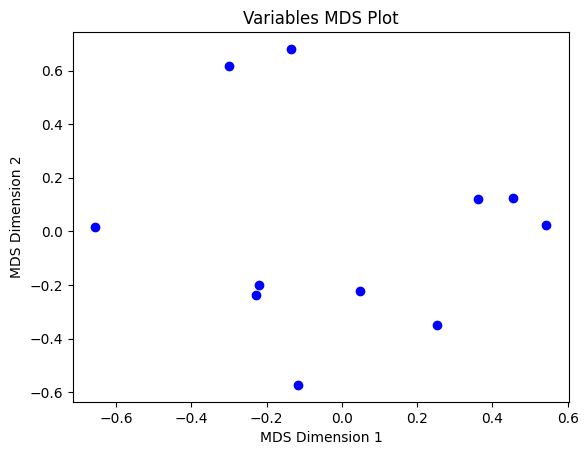

In [65]:

plt.scatter(variables_mds_result[:, 0], variables_mds_result[:, 1], c='blue')
plt.title('Variables MDS Plot')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

In [66]:
import json


# Create a list of dictionaries
data_mds_list = []
for i in range(len(variables_mds_result)):
    data_mds_dict = {'x': float(variables_mds_result[i][0]), 'y': float(variables_mds_result[i][1]), 'name': data.columns[i]}
    data_mds_list.append(data_mds_dict)

# Specify the file path
file_path = 'variables_mds_list.json'

# Convert the data_mds_list to JSON format
data_mds_list_json = json.dumps(data_mds_list)

# Write the JSON data to the file
with open(file_path, 'w') as file:
    file.write(data_mds_list_json)